In [10]:
import pandas as pd

data_full = pd.read_excel("../data/Capstone_Final_Dataset.xlsx")

In [11]:
#First I will keep only Geo info, Category info, Grant info, and Mission/Pillar info
data_full = data_full.drop(columns=[
    'Category', 
    'Geographic Scope',
    'DEI Priorities', 'Tier',
    'Verified Grant URL / Contact', 'Confirmed Application Deadlines',
    'Strategic Note / Pitch Angle', 'Partnership Potential',
    'Best Pitch Angle', 'Enhanced Notes', 'Contact Person', 'Typical Grant Size',
    'Application Process'
])


In [12]:
mask = (
    (data_full['Financial Funder'] == 1) &
    data_full['Typical Min. Grant Size'].notna() &
    data_full['Typical Max. Grant Size'].notna()
)
data_full = data_full.loc[mask].copy()


# As a first pass of the data analysis i will only keep the orgs that are financial funders! I.e. labeled 1 in the Financial Funder column

In [13]:
data_full.columns

Index(['Organization', 'Crowdfunding', 'Collegiate', 'Pro Sports League',
       'Pro Sports (NFL)', 'Pro Sports (MLB)', 'Pro Sports (USL)',
       'Pro Sports (NBA)', 'Pro Sports (MLS)', 'Pro Sports (NHL)',
       'Thought Leader', 'National Non-Profit', 'Federal Grant',
       'Venture Capital', 'Athlete Foundation', 'Corporate Foundation',
       'Education Foundation', 'Geo_Focus', 'Mission / Stated Pillars',
       'Financial Funder', 'Typical Min. Grant Size',
       'Typical Max. Grant Size', 'Label'],
      dtype='object')

I will see what unique toekns we have in mission/pillar to i know what to remove before embedding.
REMINDER!!! The regex will need to change based on the unqie tokens which will change if we change the data of add any more orgs in the data.

In [14]:
import re

# Combine all text in the column into one string
text = " ".join(data_full["Mission / Stated Pillars"].astype(str))

# Split by spaces and punctuation
tokens = re.findall(r"\b\w+\b|[^\w\s]", text)

# Get unique tokens
unique_tokens = sorted(set(tokens))

# Display
print(unique_tokens)
print(f"\nTotal unique tokens: {len(unique_tokens)}")

['$', '&', "'", '(', ')', ',', '-', '.', '/', '000', '10', '100', '12', '14', '2025', '24', '50', '6th', '8th', ':', ';', 'A', 'AI', 'Access', 'Advances', 'Alberta', 'All', 'Almost', 'Anaheim', 'Angeles', 'Animal', 'Application', 'Area', 'Arizona', 'Arts', 'Assist', 'Atlanta', 'Augusta', 'Autism', 'Baltimore', 'Bay', 'Being', 'Berkeley', 'Black', 'Brilliant', 'Bronx', 'Brooklyn', 'C', 'Care', 'Career', 'Carolina', 'Celtics', 'Central', 'Change', 'Charitable', 'Charities', 'Chicagoland', 'Children', 'Civic', 'ClassDojo', 'Committed', 'Communities', 'Community', 'Concept', 'Conservation', 'D', 'Dedicated', 'Degreed', 'Degrees', 'Development', 'Distributes', 'Diversity', 'DonorsChoose', 'Durham', 'Dynamic', 'Eagles', 'Eat', 'Economic', 'Educate', 'Education', 'Elevate', 'Employment', 'Empower', 'Empowering', 'Encourages', 'England', 'Enhanced', 'Ensure', 'Entertainment', 'Environmental', 'Equal', 'Extends', 'Facilitates', 'Families', 'Florida', 'Focus', 'Focuses', 'Football', 'Fort', 'Fos

clean_mission is a light, semantics-safe text cleaner designed for SentenceTransformer embeddings. It first normalizes curly quotes, long dashes, and ellipses to simple ASCII equivalents, then strips URLs and emails. It removes money mentions (e.g., $5,000, $5k, $1.2M), year ranges (e.g., 2024–2025) and single years from 1900–2099, and geographic references found in a small built-in list (e.g., north carolina, new york, arizona, houston). It also drops standalone punctuation characters & ' ( ) / , . : ; (while keeping in-word hyphens, so terms like k-12 and after-school survive), and removes standalone numbers that aren’t part of words (so k-12 is preserved but 50 is removed). Finally, it lowercases and collapses whitespace.
Note: the place removal relies on the _PLACES list defined at the top; if you add more organizations or new locations appear, you should update _PLACES (and re-compile) so those geographic terms are also removed.

In [15]:
import re
import pandas as pd

# --- compile once (fast) ---

# Places expanded from your token list (keep multi-word first)
_PLACES = [
    # multi-word first
    "los angeles", "new york", "north carolina", "south carolina", "fort worth",
    "tampa bay", "kansas city",
    # cities / regions / states / provinces / countries seen in list
    "anaheim", "atlanta", "augusta", "baltimore", "berkeley", "bronx", "brooklyn",
    "durham", "england", "florida", "houston", "indiana", "jersey", "madison",
    "michigan", "midwest", "minnesota", "oakland", "ontario", "philadelphia",
    "pittsburgh", "south", "tampa", "tennessee", "texas", "utah", "waco",
    "western", "wisconsin", "york", "alberta",
    # common abbreviations/short forms from list
    "la", "nyc", "kc", "nyy", "waco"
]
_PLACES_RX = re.compile(
    r"\b(" + "|".join(map(re.escape, sorted(_PLACES, key=len, reverse=True))) + r")\b",
    re.IGNORECASE
)

URL_EMAIL_RX      = re.compile(r"https?://\S+|www\.\S+|\S+@\S+")
YEAR_RANGE_RX     = re.compile(r"\b(?:19|20)\d{2}\s*[-–—]\s*(?:19|20)\d{2}\b")
YEAR_RX           = re.compile(r"\b(?:19|20)\d{2}\b")          # 1900–2099

# $5k, $5,000, $ 250, $1.2M (requires $ by design, as specified)
MONEY_RX          = re.compile(r"\$\s?\d[\d,]*(?:\.\d+)?\s*[kKmMbB]?")

# Remove bare numbers and simple ordinals, but keep in-word hyphens like k-12
STANDALONE_NUM_RX = re.compile(r"(?<![A-Za-z-])\b\d+\b(?![A-Za-z-])")
ORDINAL_RX        = re.compile(r"\b\d+(?:st|nd|rd|th)\b", re.IGNORECASE)

# Drop standalone punctuation (we’ll keep in-word hyphens via a later rule)
PUNCT_RX          = re.compile(r"[\$&'()/,.:;]")

def clean_mission(text: str) -> str:
    """Light, semantics-safe cleaner for SentenceTransformers."""
    if pd.isna(text):
        return ""
    s = str(text).strip()

    # normalize unicode punctuation variants
    s = (s.replace("’","'").replace("‘","'")
           .replace("“",'"').replace("”",'"')
           .replace("—","-").replace("–","-").replace("…","."))

    # remove urls/emails, money, years, locations
    s = URL_EMAIL_RX.sub(" ", s)
    s = MONEY_RX.sub(" ", s)
    s = YEAR_RANGE_RX.sub(" ", s)
    s = YEAR_RX.sub(" ", s)
    s = _PLACES_RX.sub(" ", s)

    # drop standalone punctuation (keep in-word hyphens like k-12)
    s = PUNCT_RX.sub(" ", s)
    s = re.sub(r"(?<!\w)-(?!\w)", " ", s)   # drop stray hyphens (not in-word)

    # remove standalone numbers and ordinals (but keep things like k-12)
    s = STANDALONE_NUM_RX.sub(" ", s)
    s = ORDINAL_RX.sub(" ", s)

    # lowercase + collapse whitespace
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [16]:
data_full['mission_clean'] = data_full['Mission / Stated Pillars'].apply(clean_mission)


In [17]:
import re
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

def print_cluster_terms_safe(
    texts,
    labels,
    topn=12,
    method="relative",      # "relative" or "mean"
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    extra_stops=None,
    include_noise=False,
    min_cluster_size_to_print=1,
    verbose=True
):
    labels = np.asarray(labels)
    uniq, cnts = np.unique(labels, return_counts=True)
    if verbose:
        print("Label distribution:", dict(zip(uniq.tolist(), cnts.tolist())))

    if extra_stops is None:
        extra_stops = {
            "foundation","nonprofit","program","programs",
            "students","youth","community","support",
            "organization","organizations"
        }
    stopwords = list(ENGLISH_STOP_WORDS.union(extra_stops))

    docs = ["" if t is None else str(t) for t in texts]

    def try_vectorizer(_min_df, _max_df, _ngram_range, _stopwords):
        tfidf = TfidfVectorizer(
            stop_words=_stopwords,
            ngram_range=_ngram_range,
            min_df=_min_df,
            max_df=_max_df,
            sublinear_tf=True
        )
        X = tfidf.fit_transform(docs)
        terms = np.array(tfidf.get_feature_names_out())
        return X, terms

    Xtf = terms = None
    # Progressive relaxation if vocab is empty
    relax_plan = [
        (min_df,   max_df,   ngram_range, stopwords),
        (1,        max_df,   ngram_range, stopwords),
        (1,        1.0,      (1,1),       stopwords),
        (1,        1.0,      (1,1),       None),        # no stopwords at all
    ]

    for (md, mx, ngr, sw) in relax_plan:
        try:
            Xtf, terms = try_vectorizer(md, mx, ngr, sw)
            if verbose:
                print(f"Vectorizer OK with min_df={md}, max_df={mx}, ngram_range={ngr}, "
                      f"stopwords={'custom' if sw is not None else 'None'}; vocab={len(terms)}")
            break
        except ValueError as e:
            if "empty vocabulary" in str(e).lower():
                if verbose:
                    print(f"Retrying vectorizer due to empty vocabulary... tried "
                          f"min_df={md}, max_df={mx}, ngram_range={ngr}, "
                          f"stopwords={'custom' if sw is not None else 'None'}")
                continue
            else:
                raise

    if Xtf is None or Xtf.shape[1] == 0:
        # Final ultra-safe fallback: simple token counts without sklearn
        if verbose:
            print("Falling back to simple token counts (regex).")
        token_pat = re.compile(r"[A-Za-z]{3,}")
        tokenized = [token_pat.findall(d.lower()) for d in docs]
        labels_list = labels.tolist()
        for cid in sorted(set(labels_list)):
            if cid == -1 and not include_noise:
                continue
            idx = [i for i, l in enumerate(labels_list) if l == cid]
            if len(idx) < min_cluster_size_to_print:
                continue
            bag = Counter()
            for i in idx:
                bag.update(tokenized[i])
            common = [w for w, _ in bag.most_common(topn)]
            print(f"\nCluster {cid} (n={len(idx)}): " + ", ".join(common))
        return

    # Use non-noise docs for corpus_mean; if all noise, use all
    valid_mask = (labels != -1) if (labels != -1).any() else np.ones_like(labels, dtype=bool)
    corpus_mean = np.asarray(Xtf[valid_mask].mean(axis=0)).ravel() + 1e-9

    printed_any = False
    for cid in sorted(set(labels)):
        if cid == -1 and not include_noise:
            continue
        idx = np.where(labels == cid)[0]
        if len(idx) < min_cluster_size_to_print:
            continue
        Xc = Xtf[idx]
        mean_tfidf = np.asarray(Xc.mean(axis=0)).ravel()
        score = (mean_tfidf / corpus_mean) if method == "relative" else mean_tfidf
        if score.size == 0:
            continue
        top = score.argsort()[::-1][:topn]
        print(f"\nCluster {cid} (n={len(idx)}): " + ", ".join(terms[top]))
        printed_any = True

    if not printed_any and verbose:
        print("No clusters printed (likely all noise or clusters < min_cluster_size_to_print). "
              "Consider lowering HDBSCAN min_cluster_size/min_samples or set include_noise=True.")


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from matplotlib.lines import Line2D

def plot_clusters_with_stars_and_iterlight(model_key,
                                           title_prefix="Mission-Statement Clusters"):
    """
    - Plots 2D UMAP for the selected model_key from CLUSTER_RESULTS
    - Dots = label != 1
    - Stars = label == 1
    - Big 'X' marker for IterLight (distinct symbol)
    """
    # --- pull artifacts for this model ---
    E = CLUSTER_RESULTS[model_key]["embeddings"]
    labels = CLUSTER_RESULTS[model_key]["labels"]

    # --- 2D UMAP for visualization (do NOT use for clustering) ---
    um_2d = umap.UMAP(
        n_neighbors=UMAP_NEIGHBORS,
        n_components=2,
        min_dist=UMAP_MIN_DIST,
        metric="cosine",
        random_state=42
    )
    X_2d = um_2d.fit_transform(E)

    # --- masks ---
    star_mask = (data_full["Label"].fillna(0).astype(int).to_numpy() == 1)

    # robust match for IterLight by name in your DataFrame (adjust column if needed)
    org_col = "Organization" if "Organization" in data_full.columns else data_full.columns[0]
    iter_mask = data_full[org_col].astype(str).str.contains(r"\biter\s*light\b", case=False, na=False).to_numpy()
    # if your org name is exactly "IterLight", a simpler check also works:
    # iter_mask = data_full[org_col].astype(str).str.strip().str.lower().eq("iterlight").to_numpy()

    unique_clusters = np.unique(labels)

    # --- plotting ---
    plt.figure(figsize=(9, 7))

    # dots first (label != 1)
    for cid in unique_clusters:
        mask = (labels == cid) & (~star_mask)
        if not np.any(mask):
            continue
        if cid == -1:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                        s=35, alpha=0.5, c='lightgray', label="Noise (-1)")
        else:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                        s=55, alpha=0.8, label=f"Cluster {cid}")

    # stars (Label == 1) overlay second
    for cid in unique_clusters:
        mask = (labels == cid) & (star_mask)
        if not np.any(mask):
            continue
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    s=140, marker='*', linewidths=0.8, edgecolors='k',
                    alpha=0.95, c='gold', label=None)

    # IterLight marker: large X with contrasting edge
    if np.any(iter_mask):
        plt.scatter(X_2d[iter_mask, 0], X_2d[iter_mask, 1],
                    s=220, marker='X', c='red', edgecolors='k', linewidths=1.2,
                    alpha=0.95, label=None)

    # legends
    # 1) clusters legend
    first_legend = plt.legend(loc='best', title="Clusters", frameon=True)
    plt.gca().add_artist(first_legend)

    # 2) markers legend
    star_legend = Line2D([0], [0], marker='*', color='w', label='Label == 1 (star)',
                         markeredgecolor='k', markerfacecolor='gold', markersize=12, linewidth=0)
    dot_legend  = Line2D([0], [0], marker='o', color='w', label='Label != 1 (dot)',
                         markeredgecolor='k', markerfacecolor='k', markersize=7, linewidth=0)
    x_legend    = Line2D([0], [0], marker='X', color='w', label='IterLight',
                         markeredgecolor='k', markerfacecolor='red', markersize=10, linewidth=0)
    plt.legend(handles=[star_legend, dot_legend, x_legend],
               loc='lower left', title="Special markers", frameon=True)

    plt.title(f"{title_prefix} — {model_key} (stars mark Label==1, X marks IterLight)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# === Cell 1: Imports, model list, params ===
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# If you defined print_cluster_terms_safe earlier, it will be used later.

# Four strong general-purpose embedders
EMBEDDERS = {
    "mpnet": "sentence-transformers/all-mpnet-base-v2",
    "bge_large": "BAAI/bge-large-en-v1.5",
    "e5_large": "intfloat/e5-large-v2",
    "gte_large": "Alibaba-NLP/gte-large-en-v1.5",
}

# UMAP & HDBSCAN params
UMAP_COMPONENTS_FOR_CLUSTER = 15    # use 10–20 typically
UMAP_COMPONENTS_FOR_PLOT = 2        # 2D for visualization
UMAP_NEIGHBORS = 10
UMAP_MIN_DIST = 0.1

HDB_MIN_CLUSTER_SIZE = 5
HDB_SELECTION = "eom"

# Container for results (per model)
CLUSTER_RESULTS = {}

In [20]:
# === Cell 2: Fit all models (embeddings -> UMAP-> HDBSCAN) ===
texts = data_full["mission_clean"].astype(str).tolist()

def load_st_model(name: str):
    try:
        return SentenceTransformer(name)
    except ValueError as e:
        if "trust_remote_code" in str(e).lower():
            # Re-try with trust_remote_code for repos like gte-large
            return SentenceTransformer(name, trust_remote_code=True)
        raise

for key, model_name in EMBEDDERS.items():
    print(f"\n=== Running model: {key} -> {model_name} ===")
    model = load_st_model(model_name)

    # 1) Embeddings (L2-normalized -> cosine ≈ euclidean)
    E = model.encode(texts, normalize_embeddings=True, show_progress_bar=False)

    # 2) UMAP for clustering (to 15D by default)
    um_cluster = umap.UMAP(
        n_neighbors=UMAP_NEIGHBORS,
        n_components=UMAP_COMPONENTS_FOR_CLUSTER,
        min_dist=UMAP_MIN_DIST,
        metric="cosine",
        random_state=42
    )
    X_umap = um_cluster.fit_transform(E)

    # 3) HDBSCAN on UMAP-reduced space
    clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=HDB_MIN_CLUSTER_SIZE,
        cluster_selection_method=HDB_SELECTION
    )
    labels = clusterer.fit_predict(X_umap)

    data_full[f"cluster_mission__{key}"] = labels
    CLUSTER_RESULTS[key] = {
        "model_name": model_name,
        "embeddings": E,
        "X_umap_cluster": X_umap,
        "labels": labels,
        "umap_cluster_obj": um_cluster,
        "hdbscan_obj": clusterer,
    }

    uniq, cnts = np.unique(labels, return_counts=True)
    print("Label distribution:", dict(zip(uniq.tolist(), cnts.tolist())))
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = float(np.mean(labels == -1))
    print(f"clusters={n_clusters} | noise={noise_frac:.2%}")



=== Running model: mpnet -> sentence-transformers/all-mpnet-base-v2 ===


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Label distribution: {0: 14, 1: 138}
clusters=2 | noise=0.00%

=== Running model: bge_large -> BAAI/bge-large-en-v1.5 ===


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Label distribution: {-1: 43, 0: 17, 1: 25, 2: 7, 3: 11, 4: 37, 5: 12}
clusters=6 | noise=28.29%

=== Running model: e5_large -> intfloat/e5-large-v2 ===


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Label distribution: {-1: 36, 0: 26, 1: 40, 2: 11, 3: 39}
clusters=4 | noise=23.68%

=== Running model: gte_large -> Alibaba-NLP/gte-large-en-v1.5 ===
Label distribution: {-1: 35, 0: 12, 1: 32, 2: 19, 3: 20, 4: 19, 5: 15}
clusters=6 | noise=23.03%


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
# === Cell 3: Print top terms for a chosen model ===
# Choose which model to inspect (one of: "mpnet", "bge_large", "e5_large", "gte_large")
MODEL_KEY = "mpnet"  # <-- change this to inspect others

labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True to also see -1
    min_cluster_size_to_print=2
)


Label distribution: {0: 14, 1: 138}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=301

Cluster 0 (n=14): hockey, pediatric, growth, growth hockey, entertainment teams, leaf, teams focuses, maple leaf, maple, leaf sports, using sport, sport improve

Cluster 1 (n=138): focus, non, supporting, non profits, profits, education health, area, soccer, families, focuses supporting, grant, school


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/n6/6_dwq_bx4v7_20bszmc0y28w0000gn/T/ipykernel_12213/3943281015.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # more colors if many clusters


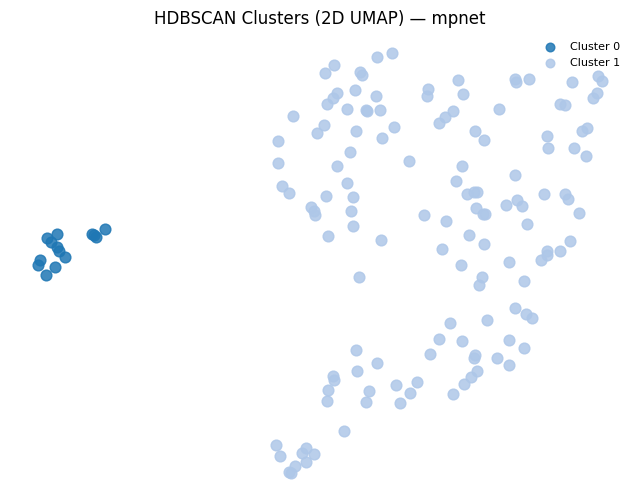

In [22]:
# === Cell 4: 2D UMAP + Scatter plot for the same model ===
from matplotlib.cm import get_cmap

MODEL_KEY = "mpnet"  # keep in sync with cell 3 (or set differently on purpose)
E = CLUSTER_RESULTS[MODEL_KEY]["embeddings"]
labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

# 2D projection for visualization
um_2d = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    n_components=UMAP_COMPONENTS_FOR_PLOT,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=42
)
X_2d = um_2d.fit_transform(E)

# Plot
unique_labels = np.unique(labels)
n_lab = len(unique_labels)
cmap = get_cmap("tab20")  # more colors if many clusters

plt.figure(figsize=(8, 6))
for i, lab in enumerate(unique_labels):
    mask = (labels == lab)
    if lab == -1:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[(0.6, 0.6, 0.6)], s=35, alpha=0.6, label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[cmap(i % cmap.N)], s=60, alpha=0.85, label=f"Cluster {lab}")

plt.title(f"HDBSCAN Clusters (2D UMAP) — {MODEL_KEY}")
plt.legend(loc="best", fontsize=8, markerscale=0.8, frameon=False)
plt.axis("off")
plt.show()


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


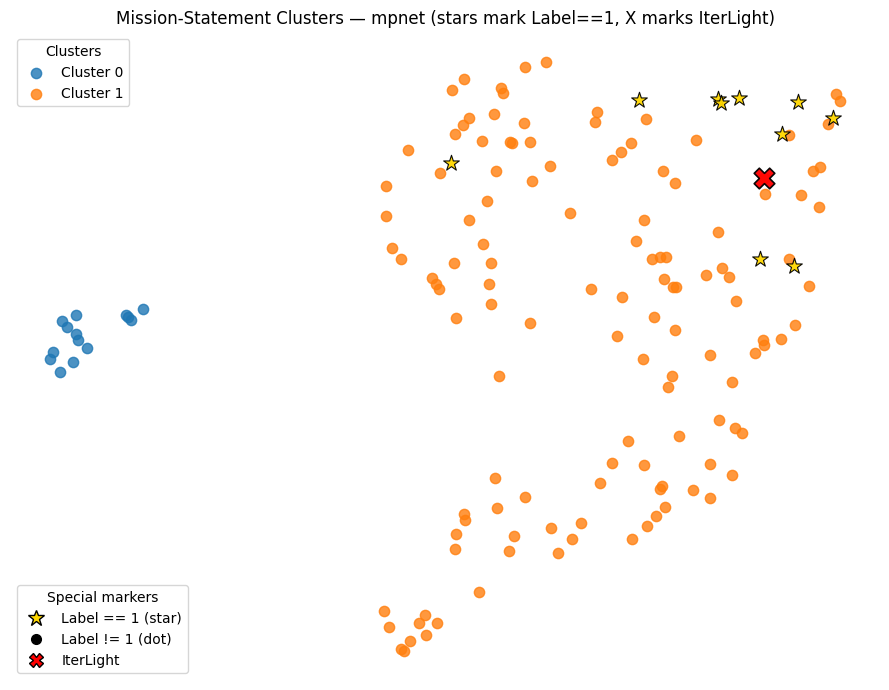

In [23]:
# Plot for one model (set to the one you want)
plot_clusters_with_stars_and_iterlight("mpnet")


In [24]:
# === Cell 3: Print top terms for a chosen model ===
# Choose which model to inspect (one of: "mpnet", "bge_large", "e5_large", "gte_large")
MODEL_KEY = "bge_large"  # <-- change this to inspect others

labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True to also see -1
    min_cluster_size_to_print=2
)


Label distribution: {-1: 43, 0: 17, 1: 25, 2: 7, 3: 11, 4: 37, 5: 12}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=301

Cluster 0 (n=17): world, evidence, portfolio, funds, scale, companies, entrepreneurial, ai, curriculum, portfolio includes, includes, innovative

Cluster 1 (n=25): supports non, profits focus, profits serve, profits area, supports local, local non, schools, supporting non, local school, grants non, non profit, profit

Cluster 2 (n=7): career, education wellness, focusing, development social, supports health, mentoring, health fitness, fitness, football, athletics, sports education, advancement

Cluster 3 (n=11): hockey, pediatric, cancer, care, growth, growth hockey, homelessness, resources, supports broader, children health, supports children, wellness education

Cluster 4 (n=37): betterment, supports focus, initiative, dedicated supporting, supporting development, work, greater, focus health, grant key, emphasis, emphasis educ

/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/n6/6_dwq_bx4v7_20bszmc0y28w0000gn/T/ipykernel_12213/1053210812.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # more colors if many clusters


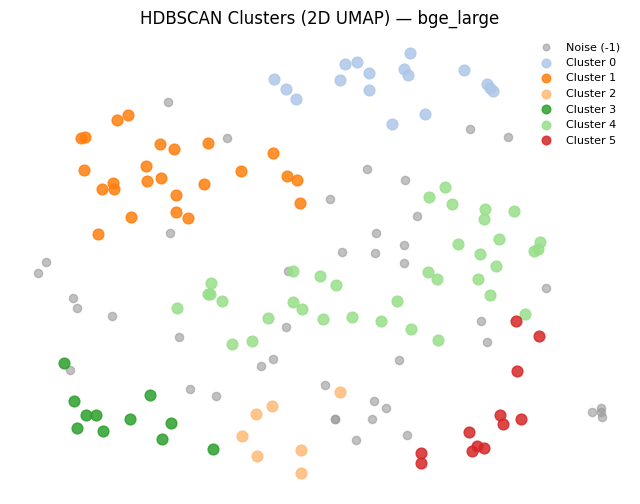

In [25]:
# === Cell 4: 2D UMAP + Scatter plot for the same model ===
from matplotlib.cm import get_cmap

MODEL_KEY = "bge_large"  # keep in sync with cell 3 (or set differently on purpose)
E = CLUSTER_RESULTS[MODEL_KEY]["embeddings"]
labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

# 2D projection for visualization
um_2d = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    n_components=UMAP_COMPONENTS_FOR_PLOT,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=42
)
X_2d = um_2d.fit_transform(E)

# Plot
unique_labels = np.unique(labels)
n_lab = len(unique_labels)
cmap = get_cmap("tab20")  # more colors if many clusters

plt.figure(figsize=(8, 6))
for i, lab in enumerate(unique_labels):
    mask = (labels == lab)
    if lab == -1:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[(0.6, 0.6, 0.6)], s=35, alpha=0.6, label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[cmap(i % cmap.N)], s=60, alpha=0.85, label=f"Cluster {lab}")

plt.title(f"HDBSCAN Clusters (2D UMAP) — {MODEL_KEY}")
plt.legend(loc="best", fontsize=8, markerscale=0.8, frameon=False)
plt.axis("off")
plt.show()


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


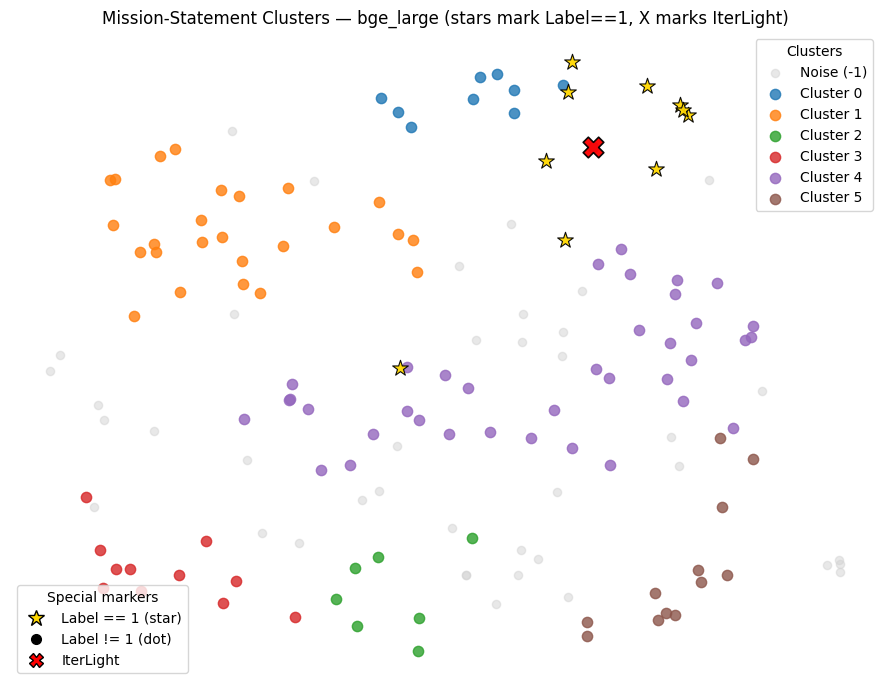

In [26]:
# Plot for one model (set to the one you want)
plot_clusters_with_stars_and_iterlight("bge_large")

In [27]:
# === Cell 3: Print top terms for a chosen model ===
# Choose which model to inspect (one of: "mpnet", "bge_large", "e5_large", "gte_large")
MODEL_KEY = "e5_large"  # <-- change this to inspect others

labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True to also see -1
    min_cluster_size_to_print=2
)


Label distribution: {-1: 36, 0: 26, 1: 40, 2: 11, 3: 39}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=301

Cluster 0 (n=26): region, focus development, club, betterment, supporting development, dedicated supporting, education athletics, emphasis, area emphasis, emphasis education, basketball, enrich

Cluster 1 (n=40): non, profits, non profits, funds, profits focus, research, projects, supports non, 12, portfolio, local non, supports local

Cluster 2 (n=11): hockey, pediatric, cancer, growth, growth hockey, resources, supports broader, children health, supports children, access, homelessness, workforce development

Cluster 3 (n=39): social, physical, mission, people, health safety, safety, football, literacy, recreation, supports health, impact, engagement


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/n6/6_dwq_bx4v7_20bszmc0y28w0000gn/T/ipykernel_12213/1416614940.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # more colors if many clusters


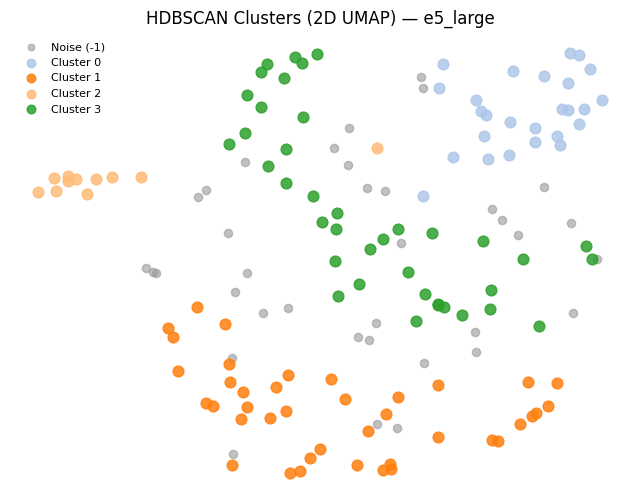

In [28]:
# === Cell 4: 2D UMAP + Scatter plot for the same model ===
from matplotlib.cm import get_cmap

MODEL_KEY = "e5_large"  # keep in sync with cell 3 (or set differently on purpose)
E = CLUSTER_RESULTS[MODEL_KEY]["embeddings"]
labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

# 2D projection for visualization
um_2d = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    n_components=UMAP_COMPONENTS_FOR_PLOT,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=42
)
X_2d = um_2d.fit_transform(E)

# Plot
unique_labels = np.unique(labels)
n_lab = len(unique_labels)
cmap = get_cmap("tab20")  # more colors if many clusters

plt.figure(figsize=(8, 6))
for i, lab in enumerate(unique_labels):
    mask = (labels == lab)
    if lab == -1:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[(0.6, 0.6, 0.6)], s=35, alpha=0.6, label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[cmap(i % cmap.N)], s=60, alpha=0.85, label=f"Cluster {lab}")

plt.title(f"HDBSCAN Clusters (2D UMAP) — {MODEL_KEY}")
plt.legend(loc="best", fontsize=8, markerscale=0.8, frameon=False)
plt.axis("off")
plt.show()


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


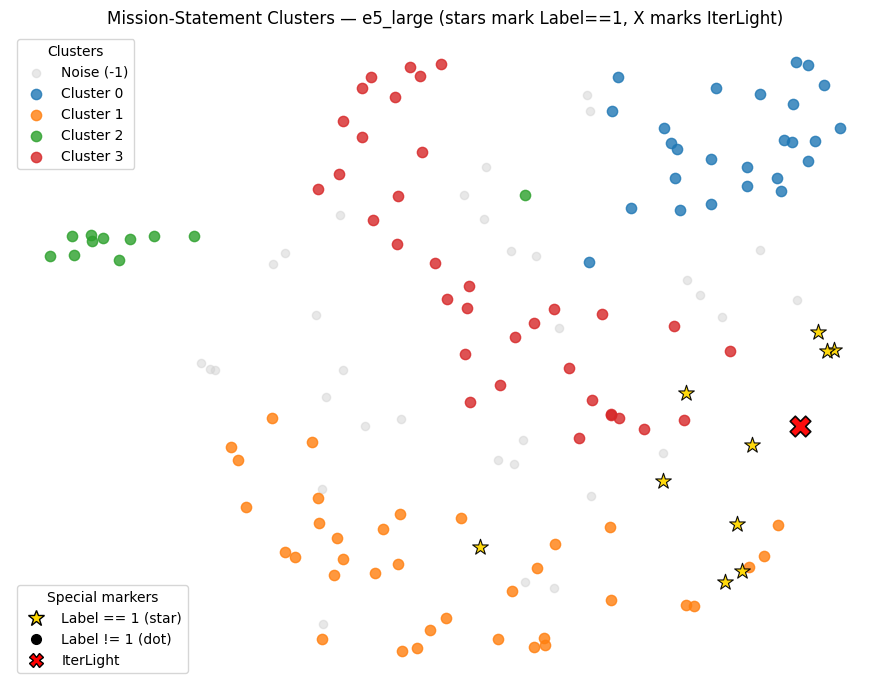

In [29]:
# Plot for one model (set to the one you want)
plot_clusters_with_stars_and_iterlight("e5_large")

In [30]:
# === Cell 3: Print top terms for a chosen model ===
# Choose which model to inspect (one of: "mpnet", "bge_large", "e5_large", "gte_large")
MODEL_KEY = "gte_large"  # <-- change this to inspect others

labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True to also see -1
    min_cluster_size_to_print=2
)


Label distribution: {-1: 35, 0: 12, 1: 32, 2: 19, 3: 20, 4: 19, 5: 15}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=301

Cluster 0 (n=12): hockey, pediatric, growth, growth hockey, entertainment teams, maple leaf, maple, leaf sports, leaf, teams focuses, cancer, using sport

Cluster 1 (n=32): soccer, athletics, football, education athletics, basketball, game, sports education, improving, lives children, charitable, power, handled

Cluster 2 (n=19): initiative, supporting development, dedicated supporting, leadership development, grant key, racial equity, racial, enrich, programming, emphasis, area emphasis, emphasis education

Cluster 3 (n=20): projects, schools, scale, companies, student, local school, portfolio, curriculum, college access, college, primarily, ohio

Cluster 4 (n=19): focus health, family health, education family, physical, strong school, wellness strong, employment, young, health inclusion, inclusion, works, diversity education


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/n6/6_dwq_bx4v7_20bszmc0y28w0000gn/T/ipykernel_12213/3498102588.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # more colors if many clusters


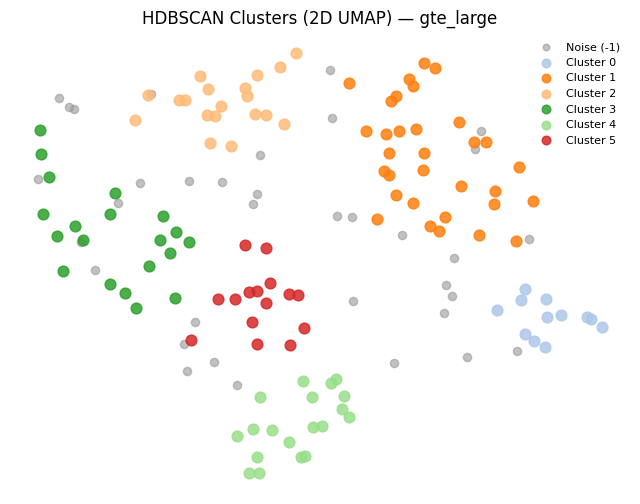

In [31]:
# === Cell 4: 2D UMAP + Scatter plot for the same model ===
from matplotlib.cm import get_cmap

MODEL_KEY = "gte_large"  # keep in sync with cell 3 (or set differently on purpose)
E = CLUSTER_RESULTS[MODEL_KEY]["embeddings"]
labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

# 2D projection for visualization
um_2d = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    n_components=UMAP_COMPONENTS_FOR_PLOT,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=42
)
X_2d = um_2d.fit_transform(E)

# Plot
unique_labels = np.unique(labels)
n_lab = len(unique_labels)
cmap = get_cmap("tab20")  # more colors if many clusters

plt.figure(figsize=(8, 6))
for i, lab in enumerate(unique_labels):
    mask = (labels == lab)
    if lab == -1:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[(0.6, 0.6, 0.6)], s=35, alpha=0.6, label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                    c=[cmap(i % cmap.N)], s=60, alpha=0.85, label=f"Cluster {lab}")

plt.title(f"HDBSCAN Clusters (2D UMAP) — {MODEL_KEY}")
plt.legend(loc="best", fontsize=8, markerscale=0.8, frameon=False)
plt.axis("off")
plt.show()


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


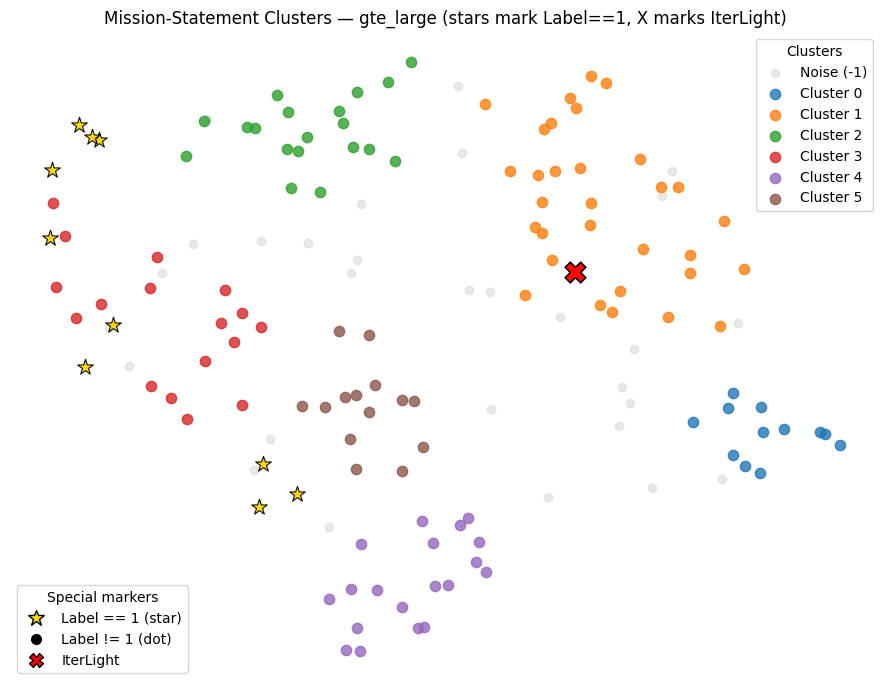

In [32]:
# Plot for one model (set to the one you want)
plot_clusters_with_stars_and_iterlight("gte_large")

In [33]:
MODEL_KEY = "gte_large"
lab_col = f"cluster_mission__{MODEL_KEY}"

# make sure the column exists (create it from CLUSTER_RESULTS if needed)
if lab_col not in data_full.columns:
    data_full[lab_col] = CLUSTER_RESULTS[MODEL_KEY]["labels"]

# pick the org-name column (adjust if yours is different)
org_col = "Organization" if "Organization" in data_full.columns else data_full.columns[0]

# find IterLight (robust match: "iter light" or "IterLight")
mask = data_full[org_col].astype(str).str.contains(r"\biter\s*light\b", case=False, na=False)

print(data_full.loc[mask, [org_col, lab_col]])


  Organization  cluster_mission__gte_large
0    IterLight                           1


# Priority Scoring via Cluster-Aware Affinity (What this code does & why)

## Overview
We build a **priority score** to rank funders by how promising they are for outreach. The score blends:
- **Affinity to IterLight** *(cosine similarity to IterLight’s embedding)*,
- **Cluster prior** *(clusters more like our “success” cluster get higher weight)*,
- **Fit confidence** *(how cleanly an org fits any cluster centroid)*.

This yields a single, interpretable number per org: higher = better outreach priority.

---

## Inputs
- `E`: embedding matrix for organizations (rows = orgs, columns = embedding dims).
- `labels`: cluster labels for each org (`-1` = noise).
- `data_full`: DataFrame with an org name column (used to find proxies and IterLight).

---

## Step-by-step

1. **Choose a target “success-like” cluster**  
   - Search org names for **proxy successes** (e.g., NSF, YC, SkyDeck, IES).  
   - If found, take the **majority cluster** among those proxies (ignore noise).  
   - If none matched, **fallback** to IterLight’s own cluster.

2. **Compute centroids (ignore noise)**  
   - For each non-noise cluster, average member embeddings → **cluster centroid**.

3. **Order clusters by similarity to the target**  
   - Compute centroid-to-centroid **cosine similarity**; rank clusters by similarity to the target.

4. **Assign explicit cluster weights**  
   - Apply a decaying weight schedule by rank (e.g., `1.0, 0.5, 0.25, …`).  
   - Encodes a **prior**: clusters more like the target count more.

5. **Soft-label noise points**  
   - For items with `-1`, assign to the **nearest centroid** by cosine similarity.  
   - Ensures every org can inherit a cluster prior.

6. **Compute the three ingredients per org**
   - `sim_to_iter`: **affinity to IterLight** (cosine similarity to IterLight’s embedding).
   - `cluster_w`: **cluster prior weight** (from step 4, after soft-labeling).
   - `soft_fit`: **fit confidence** (max cosine similarity to any centroid).
   - **Final score:**  
     \[
     \text{priority\_score} \;=\; \text{sim\_to\_iter} \times \text{cluster\_w} \times \text{soft\_fit}
     \]

7. **Store and inspect**  
   - Save `cluster_soft`, `priority_score`, and components to `data_full`.  
   - Sort and view top candidates.

---

## Rationale (why multiply these three)
- **Affinity (similarity)** captures *how much the org looks like us* (mission/semantics).  
- **Cluster prior** captures *how much the org’s neighborhood resembles known successes*.  
- **Fit confidence** reduces scores for borderline/outlier points.  
- **Product form** rewards orgs that are strong on **all** dimensions and naturally down-weights any weakness (if one factor is near 0, the score falls).

> If you prefer explicit trade-offs, z-score each term and use a **weighted sum**; the product is a clean, low-parameter default.

---

## Tunable parts
- **Proxy list:** customize to your real success set.  
- **Weight schedule:** adjust decay (e.g., `1.0, 0.7, 0.4, 0.2, 0.1`) or use a smooth function.  
- **Fit term:** drop `soft_fit` if clustering is noisy, or replace with membership probabilities.  
- **Anchor:** replace `sim_to_iter` with similarity to a **success centroid** (mean of known winners).

---

## Caveats & checks
- Ensure embeddings are **normalized** if relying on cosine geometry.  
- If neither proxies nor IterLight exist in the table, add a safe fallback for the target cluster.  
- Proxies that were included in clustering can introduce **mild label leakage**—acceptable for a heuristic OPS, but keep in mind.

---

## Interpreting the output
- `priority_score__{MODEL_KEY}`: final ranking metric.  
- `cluster_soft__{MODEL_KEY}`: cluster after soft-assignment (no more `-1`).  
- Components (`sim_to_iter__*`, `cluster_weight__*`, `soft_fit__*`) help **debug** why an org scored high/low.

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

MODEL_KEY = "gte_large"  # or "mpnet", etc.
E      = CLUSTER_RESULTS[MODEL_KEY]["embeddings"]
labels = CLUSTER_RESULTS[MODEL_KEY]["labels"]

org_col = "Organization" if "Organization" in data_full.columns else data_full.columns[0]

# --- 1) Identify the TARGET cluster via proxy success orgs ---
proxy_patterns = [
    r"\breach\b", r"\breach capital\b", r"\bnational science foundation\b", r"\bnsf\b",
    r"\bsolve\b", r"\by combinator\b|\byc\b", r"\bskydeck\b", r"\binstitute of education sciences\b|\bies\b"
]
proxy_mask = np.zeros(len(data_full), dtype=bool)
for pat in proxy_patterns:
    proxy_mask |= data_full[org_col].astype(str).str.contains(pat, case=False, na=False)

if proxy_mask.sum() == 0:
    # fallback: use IterLight's cluster as target if no proxies matched
    iter_mask = data_full[org_col].astype(str).str.contains(r"\biter\s*light\b", case=False, na=False)
    TARGET_CLUSTER = labels[iter_mask][0]
else:
    # majority cluster among proxies (ignore noise)
    lbls = labels[proxy_mask & (labels != -1)]
    TARGET_CLUSTER = pd.Series(lbls).mode()[0] if len(lbls) else -1
    if TARGET_CLUSTER == -1:
        # all proxies were noise; fall back to IterLight's cluster
        iter_mask = data_full[org_col].astype(str).str.contains(r"\biter\s*light\b", case=False, na=False)
        TARGET_CLUSTER = labels[iter_mask][0]

# --- 2) Recompute cluster centroids (ignore noise) ---
valid = labels != -1
cluster_ids = sorted(np.unique(labels[valid]))
centroids = {cid: E[(labels==cid) & valid].mean(axis=0) for cid in cluster_ids}
C = np.vstack([centroids[cid] for cid in cluster_ids])

# --- 3) Order clusters by similarity to TARGET_CLUSTER ---
t_idx = cluster_ids.index(TARGET_CLUSTER)
sim_matrix = cosine_similarity(C)
order = np.argsort(sim_matrix[t_idx])[::-1]  # descending
ordered_cids = [cluster_ids[i] for i in order]

# --- 4) Define strong, explicit weights (target > next > others) ---
base_weights = [1.0, 0.5, 0.25, 0.15, 0.10]
weights_map = {}
for rank, cid in enumerate(ordered_cids):
    w = base_weights[rank] if rank < len(base_weights) else base_weights[-1]
    weights_map[cid] = w

# --- 5) Soft-assign noise to nearest cluster ---
sim_to_centroids = cosine_similarity(E, C)              # (n_orgs, n_clusters)
nearest_idx = sim_to_centroids.argmax(axis=1)
nearest_cid = np.array([cluster_ids[i] for i in nearest_idx])
labels_soft = labels.copy()
labels_soft[labels == -1] = nearest_cid[labels == -1]   # replace noise with nearest cluster

# --- 6) Combine cluster weight × cosine(sim to IterLight) × (optional) soft fit strength ---
iter_mask = data_full[org_col].astype(str).str.contains(r"\biter\s*light\b", case=False, na=False)
iter_emb  = E[iter_mask][0]
sim_to_iter = cosine_similarity(E, [iter_emb]).ravel()

# optional: how confidently each point matches its nearest centroid
soft_fit = sim_to_centroids.max(axis=1)  # in [0,1] roughly for normalized embeddings

# final score; if you want to ignore soft_fit, drop the "* soft_fit"
cluster_w = np.array([weights_map.get(c, 0.0) for c in labels_soft])
priority_score = sim_to_iter * cluster_w * soft_fit

data_full[f"cluster_soft__{MODEL_KEY}"] = labels_soft
data_full[f"priority_score__{MODEL_KEY}"] = priority_score
data_full[f"sim_to_iter__{MODEL_KEY}"] = sim_to_iter
data_full[f"cluster_weight__{MODEL_KEY}"] = cluster_w
data_full[f"soft_fit__{MODEL_KEY}"] = soft_fit

# --- 7) Inspect the top results (exclude IterLight) ---
cols = [org_col, f"cluster_soft__{MODEL_KEY}", f"priority_score__{MODEL_KEY}",
        f"cluster_weight__{MODEL_KEY}", f"sim_to_iter__{MODEL_KEY}"]

# Exclude IterLight (and optionally other internal orgs)
internal_patterns = [r"\biter\s*light\b"]  # add more if needed
exclude_mask = np.zeros(len(data_full), dtype=bool)
for pat in internal_patterns:
    exclude_mask |= data_full[org_col].astype(str).str.contains(pat, case=False, na=False)

rank_base = data_full.loc[~exclude_mask, cols].copy()

top = (rank_base
       .sort_values(f"priority_score__{MODEL_KEY}", ascending=False)
       .head(25)
       .assign(rank=lambda df: np.arange(1, len(df) + 1)))

# sanity check: ensure IterLight not present
assert not top[org_col].str.contains(r"\biter\s*light\b", case=False, na=False).any()

top


,Organization,cluster_soft__gte_large,priority_score__gte_large,cluster_weight__gte_large,sim_to_iter__gte_large,rank
53,Golden State Warriors Community Foundation,3,0.599950,1.0,0.686366,1
58,Google for Education,3,0.596372,1.0,0.702419,2
193,Baylor University - Office of External Affairs,3,0.588456,1.0,0.671665,3
34,National Science Foundation (NSF),3,0.581254,1.0,0.710086,4
39,TGR Foundation (Tiger Woods),3,0.570105,1.0,0.690155,5
36,Reach Capital,3,0.542900,1.0,0.698892,6
50,The Ohio State University - Office of Outreach,3,0.541222,1.0,0.648720,7
195,TCU (Texas Christian University) - Community E...,3,0.534245,1.0,0.611774,8
183,University of Wisconsin-Madison - Community Re...,3,0.525543,1.0,0.621431,9
46,Bill & Melinda Gates Foundation,3,0.520992,1.0,0.628639,10


Feature	What it measures	Why it’s useful
Similarity (sim_to_IterLight)	How close the funder’s mission text is to IterLight’s mission text in embedding space.	A direct measure of semantic affinity: do they talk about the same things?
Cluster weight (cluster_weight)	How similar the region (cluster) the funder belongs to is to the “successful” region of known EdTech funders.	A measure of contextual alignment: do they live in the same “neighborhood” of funders that tend to support things like IterLight?
Soft fit (soft_fit)	How strongly the funder belongs to a well-defined cluster.	A measure of confidence or typicality: do they clearly fit into a known thematic area, or are they an outlier / ambiguous?

conceptually:
Similarity = “Are they like us?”
Cluster = “Are they like the orgs who traditionally support things like us?”
Soft fit = “How confidently can we say that?”

In [35]:
sim_matrix = cosine_similarity(C)
order = np.argsort(sim_matrix[t_idx])[::-1]
ordered_cids = [cluster_ids[i] for i in order]


In [36]:
print("Cluster similarity to Cluster 0:")
for cid, sim in zip(cluster_ids, sim_matrix[t_idx]):
    print(f"  Cluster {cid}: {sim:.3f}")

# show the order explicitly
print("\nOrdered by similarity to Cluster 0 (descending):", ordered_cids)


Cluster similarity to Cluster 0:
  Cluster 0: 0.759
  Cluster 1: 0.856
  Cluster 2: 0.887
  Cluster 3: 1.000
  Cluster 4: 0.862
  Cluster 5: 0.889

Ordered by similarity to Cluster 0 (descending): [np.int64(3), np.int64(5), np.int64(2), np.int64(4), np.int64(1), np.int64(0)]


In [37]:
count_success_c0 = int(((labels == 0) & proxy_mask).sum())
print("Success orgs in cluster 0 (raw labels):", count_success_c0)

Success orgs in cluster 0 (raw labels): 0


In [38]:
geo = np.where(data_full["Geo_Focus"] == 1, 0.7, 0.3)
p_x = priority_score * geo
print(p_x)

[0.02374693 0.2596729  0.29451284 0.14681526 0.10392324 0.0365735
 0.07485064 0.03166001 0.02087284 0.01978029 0.03345717 0.01900914
 0.02768297 0.0153206  0.01155864 0.01423504 0.02748751 0.03288225
 0.01505472 0.03720646 0.0198671  0.03850146 0.04696982 0.05121682
 0.13089885 0.26630623 0.04075514 0.03922021 0.33427575 0.40687774
 0.34226826 0.38002972 0.02033715 0.39907319 0.03926104 0.04380037
 0.35813262 0.36469438 0.01950141 0.03684358 0.16236675 0.13180813
 0.01987258 0.17998504 0.03517891 0.07599163 0.03329541 0.01757625
 0.41746032 0.08353515 0.06976308 0.04790707 0.02062574 0.02127482
 0.01820884 0.01564899 0.0794081  0.02345277 0.07326594 0.02085485
 0.01783605 0.02241057 0.02678188 0.01777453 0.01340855 0.17482114
 0.01489263 0.08453314 0.07822476 0.0373109  0.03881671 0.02226049
 0.02948135 0.07133626 0.02507887 0.03581582 0.16865271 0.01753875
 0.01930783 0.02508582 0.03768112 0.07752839 0.01605971 0.03650473
 0.04080213 0.04275644 0.08262342 0.0900951  0.18147273 0.04331

In [39]:
# --- 6b) Geography adjustment & Expected Value ---
# Geo weight: 0.7 if Geo_Focus==1 else 0.3
geo = np.where(data_full["Geo_Focus"] == 1, 0.7, 0.3)

# p(x): priority adjusted by geo
p_x = priority_score * geo
print(p_x)

# Row-wise mean of Typical Min/Max Grant Size -> ndarray
mean_typical_grant_size = data_full[['Typical Min. Grant Size', 'Typical Max. Grant Size']].mean(axis=1).to_numpy()

# Expected value: p(x) * mean grant size
expected_values = p_x * mean_typical_grant_size
print(expected_values)

# Persist to DataFrame (optional but handy)
data_full[f"geo_weight__{MODEL_KEY}"]        = geo
data_full[f"p_x_geo__{MODEL_KEY}"]           = p_x
data_full[f"mean_typical_grant__{MODEL_KEY}"] = mean_typical_grant_size
data_full[f"expected_value__{MODEL_KEY}"]    = expected_values

# --- 7) Inspect the top results by expected value ---
cols_ev = [
    org_col,
    f"expected_value__{MODEL_KEY}",
    f"p_x_geo__{MODEL_KEY}",
    f"priority_score__{MODEL_KEY}",
    f"cluster_weight__{MODEL_KEY}",
    f"sim_to_iter__{MODEL_KEY}",
    f"soft_fit__{MODEL_KEY}",
    "Geo_Focus",
    "Typical Min. Grant Size",
    "Typical Max. Grant Size",
    f"cluster_soft__{MODEL_KEY}",
]
cols_ev = [c for c in cols_ev if c in data_full.columns]

# Persist raw and soft cluster labels for visibility
data_full[f"cluster_raw__{MODEL_KEY}"]  = labels
data_full[f"cluster_soft__{MODEL_KEY}"] = labels_soft  # already computed above

# Add proxy flag (from earlier mask) and include any existing supervised label
data_full["proxy_success"] = proxy_mask.astype(int)  # 1 if matched a proxy pattern else 0

# --- 7) Inspect the top results by expected value (with clusters + labels) ---
cols_ev = [
    org_col,
    f"expected_value__{MODEL_KEY}",
    f"p_x_geo__{MODEL_KEY}",
    f"priority_score__{MODEL_KEY}",
    f"cluster_raw__{MODEL_KEY}",
    f"cluster_soft__{MODEL_KEY}",
    f"cluster_weight__{MODEL_KEY}",
    f"sim_to_iter__{MODEL_KEY}",
    f"soft_fit__{MODEL_KEY}",
    "Geo_Focus",
    "Typical Min. Grant Size",
    "Typical Max. Grant Size",
    "label",            # <-- include if you’ve added a supervised outcome column
    "proxy_success",    # <-- shows which were proxies
]
cols_ev = [c for c in cols_ev if c in data_full.columns]

top_ev = (data_full
          .loc[:, cols_ev]
          .sort_values(f"expected_value__{MODEL_KEY}", ascending=False)
          )
top_ev



[0.02374693 0.2596729  0.29451284 0.14681526 0.10392324 0.0365735
 0.07485064 0.03166001 0.02087284 0.01978029 0.03345717 0.01900914
 0.02768297 0.0153206  0.01155864 0.01423504 0.02748751 0.03288225
 0.01505472 0.03720646 0.0198671  0.03850146 0.04696982 0.05121682
 0.13089885 0.26630623 0.04075514 0.03922021 0.33427575 0.40687774
 0.34226826 0.38002972 0.02033715 0.39907319 0.03926104 0.04380037
 0.35813262 0.36469438 0.01950141 0.03684358 0.16236675 0.13180813
 0.01987258 0.17998504 0.03517891 0.07599163 0.03329541 0.01757625
 0.41746032 0.08353515 0.06976308 0.04790707 0.02062574 0.02127482
 0.01820884 0.01564899 0.0794081  0.02345277 0.07326594 0.02085485
 0.01783605 0.02241057 0.02678188 0.01777453 0.01340855 0.17482114
 0.01489263 0.08453314 0.07822476 0.0373109  0.03881671 0.02226049
 0.02948135 0.07133626 0.02507887 0.03581582 0.16865271 0.01753875
 0.01930783 0.02508582 0.03768112 0.07752839 0.01605971 0.03650473
 0.04080213 0.04275644 0.08262342 0.0900951  0.18147273 0.04331

,Organization,expected_value__gte_large,p_x_geo__gte_large,priority_score__gte_large,cluster_raw__gte_large,cluster_soft__gte_large,cluster_weight__gte_large,sim_to_iter__gte_large,soft_fit__gte_large,Geo_Focus,Typical Min. Grant Size,Typical Max. Grant Size,proxy_success
33,U.S. Dept. of Education (EIR Program),2.005655e+06,0.334276,0.477537,3,3,1.00,0.600518,0.795209,1.0,2000000.0,10000000.0,0
36,Reach Capital,1.919150e+06,0.380030,0.542900,3,3,1.00,0.698892,0.776800,1.0,100000.0,10000000.0,1
45,Chan Zuckerberg Initiative (CZI),1.887359e+06,0.358133,0.511618,-1,3,1.00,0.668215,0.765649,1.0,40000.0,10500000.0,0
35,Owl Ventures,1.882475e+06,0.342268,0.488955,-1,3,1.00,0.674686,0.724714,1.0,1000000.0,10000000.0,0
46,Bill & Melinda Gates Foundation,1.568265e+06,0.364694,0.520992,3,3,1.00,0.628639,0.828761,1.0,435.0,8600000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Detroit Red Wings Foundation,8.946667e+01,0.017893,0.059644,0,0,0.10,0.646304,0.922854,0.0,5000.0,5000.0,0
208,DonorsChoose (technology classroom projects),8.929756e+01,0.148089,0.211555,5,5,0.50,0.591926,0.714803,1.0,180.0,1026.0,0
21,Boston Red Sox Foundation,5.960131e+01,0.019867,0.066224,-1,4,0.15,0.574724,0.768179,0.0,1000.0,5000.0,0
15,Tampa Bay Buccaneers Foundation,4.045523e+01,0.011559,0.038529,1,1,0.10,0.538280,0.715776,0.0,2000.0,5000.0,0


In [41]:
# --- 8) Save ranked results and build 30-org list ---

# Drop the very last row before proceeding
top_ev = top_ev.iloc[:-1].copy()

# Save full ranked results
top_ev.to_excel("final_rank_gtelarge_cos.xlsx", index=False)
print("✅ Saved as 'final_rank_gtelarge_cos.xlsx' (last row dropped)")

# --- 8b) Build 30-org list: top 15, middle 10 (±5 around median), bottom 5 ---

n = len(top_ev)
if n < 30:
    print(f"⚠️ Only {n} rows available; will include as many as possible.")

# Slices that never overlap when n ≥ 30
top15    = top_ev.iloc[:min(15, n)].copy()
bottom5  = top_ev.iloc[max(n-5, 0):].copy()

median_idx = n // 2
mid_start = max(median_idx - 5, 15)             # avoid top15
mid_end   = mid_start + 10
if mid_end > max(n - 5, 0):                     # avoid bottom5
    mid_end = max(n - 5, 0)
    mid_start = max(mid_end - 10, 15)

middle10 = top_ev.iloc[mid_start:mid_end].copy()

# Tag groups: 1=top, 2=middle, 3=bottom
top15["rank_group"]    = 1
middle10["rank_group"] = 2
bottom5["rank_group"]  = 3

# Combine and deduplicate
keep_cols = [org_col, "rank_group"]
final_30 = (
    pd.concat([top15[keep_cols], middle10[keep_cols], bottom5[keep_cols]], axis=0)
      .drop_duplicates(subset=[org_col])
      .head(30)
)

# Save 30-org subset
final_30.to_excel("final_rank_30_gtelarge_cos.xlsx", index=False)
print("✅ Saved 30-org list with rank_group to 'final_rank_30_gtelarge_cos.xlsx'")


✅ Saved as 'final_rank_gtelarge_cos.xlsx' (last row dropped)
✅ Saved 30-org list with rank_group to 'final_rank_30_gtelarge_cos.xlsx'
